<a href="https://colab.research.google.com/github/rlrocha90/IAeML-Treinamento/blob/main/yolo_sam_roboflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

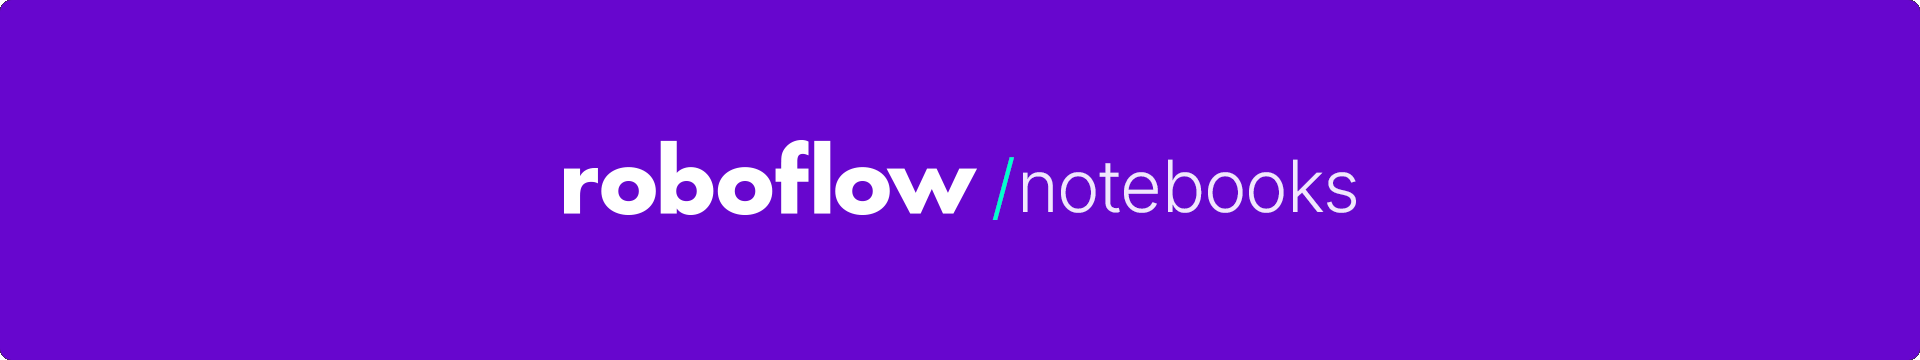

# How to Use YOLOv8 with SAM

This notebook aims to provide a step-by-step walkthrough of the process involved in leveraging the power of YOLOv8 and the Segment Anything Model (SAM) for object detection and segmentation tasks.

Here's an overview of the different sections covered in this notebook:

1. Load Dataset: We will use [VKRRR Dataset](https://universe.roboflow.com/vkr-v2/vkrrr)

2. Set YOLOv8: Here, we will set up the YOLOv8 model. You'll see how to configure the model and load the pre-trained weights for your specific use case. This part focuses on using the YOLOv8 model to predict object bounding boxes in an input image. You'll observe how the model generates bounding box predictions.

3. Extract Bounding Box: Building upon the previous step, we'll extract the bounding box coordinates from the YOLOv8 predictions. These coordinates serve as the basis for the subsequent segmentation mask generation.

4. Convert Bounding Box to Segmentation Mask: Here, we introduce the Segment Anything Model (SAM), and convert bounding boxes into precise segmentation masks. You'll learn how to apply SAM to the bounding box coordinates obtained from YOLOv8, resulting in accurate masks that delineate the object shapes.

5. [Extra] Auto-annotate on Custom Train Dataset: In this final section, we delve into the process of auto-annotation. You'll witness how the tool can be used to annotate your custom training dataset automatically. This facilitates the creation of labeled data, an essential component for training robust computer vision models.

By following this notebook, you'll gain a comprehensive understanding of the YOLOv8 and SAM integration, enabling you to perform advanced object detection and segmentation tasks with ease. Let's get started and unlock the potential of these cutting-edge models!

## Import Packages

In [1]:
!pip install roboflow ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 856.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.8/702.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninsta

In [2]:
import ultralytics
from IPython.display import display, Image
from roboflow import Roboflow
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
ultralytics.checks()

Ultralytics YOLOv8.1.5 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.5/107.7 GB disk)


In [3]:
first_run = True
if first_run:
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-7smbfl5d
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-7smbfl5d
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=6b00d71f209a355c98f744d2340b00fb2c9f577a0ae3e207e9e22d4745816b2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-4scsxl4g/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-01-24 01:28:33--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.165.83.79, 18.165.83.44, 18.165.83.91, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.165.83

## Load Dataset

In [6]:
rf = Roboflow(api_key="D0detBOpZw0GGczdQLiS")
project = rf.workspace().project("vkrrr")
model = project.version(2).model

loading Roboflow workspace...
loading Roboflow project...


## Set YOLOv8

In [9]:
!yolo predict model=yolov8n.pt source='/content/BBox/0.jpg'

Ultralytics YOLOv8.1.5 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

image 1/1 /content/BBox/0.jpg: 288x640 1 boat, 164.8ms
Speed: 7.7ms preprocess, 164.8ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


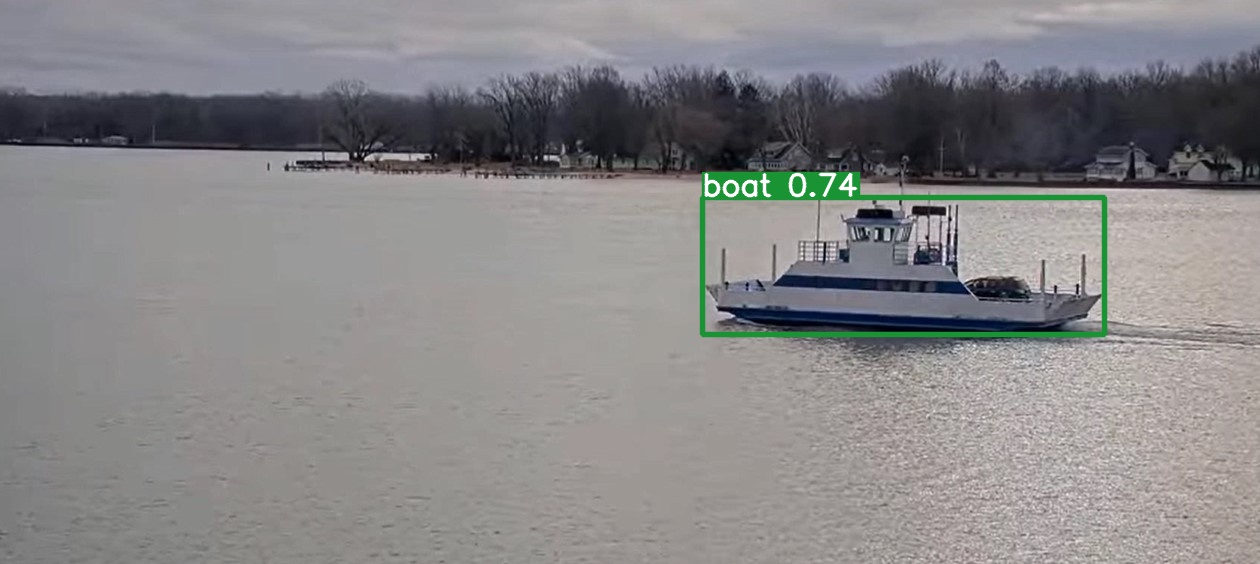

In [10]:
Image(filename='runs/detect/predict2/0.jpg', height=600)

In [11]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
results = model.predict(source='/content/BBox/0.jpg', conf=0.25)


image 1/1 /content/BBox/0.jpg: 288x640 1 boat, 311.9ms
Speed: 10.3ms preprocess, 311.9ms inference, 3.5ms postprocess per image at shape (1, 3, 288, 640)


In [12]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

## Extract Bounding Box

In [13]:
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs

bbox=boxes.xyxy.tolist()[0]

In [14]:
bbox

[702.3631591796875, 197.90980529785156, 1104.8175048828125, 334.864990234375]

In [15]:
image = cv2.cvtColor(cv2.imread('/content/BBox/0.jpg'), cv2.COLOR_BGR2RGB)

In [16]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)
predictor.set_image(image)

In [17]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [18]:
input_box = np.array(bbox)

## Convert Bounding Box to Segmentation Mask

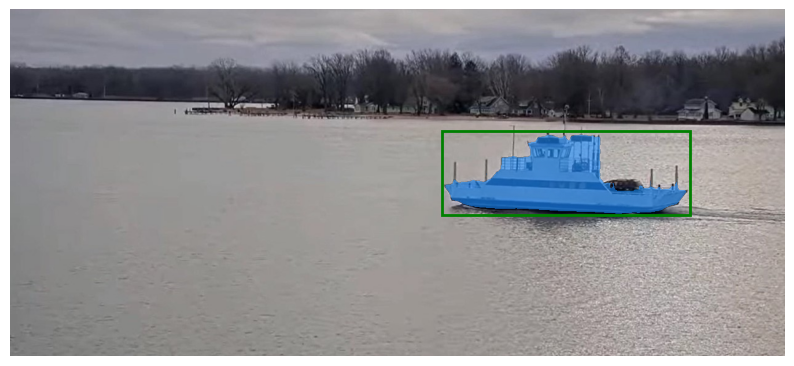

In [19]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

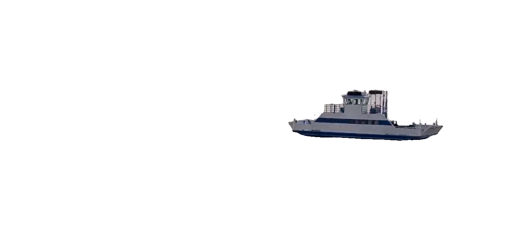

In [20]:
segmentation_mask = masks[0]
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

white_background = np.ones_like(image) * 255

new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()


  # 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.